In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

if nu.pickle_exists('tag_to_salt_df'):
    tag_to_salt_df = nu.load_object('tag_to_salt_df')
    print(tag_to_salt_df.shape)
    df = tag_to_salt_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(9874, 9)


,7710,9218,2844,7935
logger_version,1.0,1.0,1.0,1.0
session_uuid,ce1350af-79e6-475b-9c07-802b5ff5ca0a,eecb1d19-1d05-4725-9289-eb02d601cdf3,43ce12a6-e8c6-446c-bc3a-1b8820b9490f,d2e4a5df-fd46-47d5-923f-089f1ee4e1ec
time_group,2,2,0,1
patient_id,Mike_7 Root,Mike_5 Root,Mike_9 Root,Mike_7 Root
patient_count,1,1,1,1
last_tag,yellow,red,NaN,NaN
max_salt,DELAYED,IMMEDIATE,NaN,DELAYED
predicted_tag,yellow,red,NaN,yellow
is_tag_correct,True,True,False,False



# Triage Accuracy

(How many patients did they over- or under-triage.)


## Create the error table


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/error_table.png" />

In [4]:

salt_types = ['DEAD', 'EXPECTANT', 'IMMEDIATE', 'DELAYED', 'MINIMAL']
tag_colors = ['black', 'gray', 'red', 'yellow', 'green']
error_table_df = pd.DataFrame([
    {'DEAD': 'Exact', 'EXPECTANT': 'Critical', 'IMMEDIATE': 'Critical', 'DELAYED': 'Critical', 'MINIMAL': 'Critical'},
    {'DEAD': 'Over', 'EXPECTANT': 'Exact', 'IMMEDIATE': 'Critical', 'DELAYED': 'Critical', 'MINIMAL': 'Critical'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Exact', 'DELAYED': 'Over', 'MINIMAL': 'Over'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Under', 'DELAYED': 'Exact', 'MINIMAL': 'Over'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Under', 'DELAYED': 'Under', 'MINIMAL': 'Exact'}
], columns=salt_types, index=tag_colors)

In [5]:

error_table_df

,DEAD,EXPECTANT,IMMEDIATE,DELAYED,MINIMAL
black,Exact,Critical,Critical,Critical,Critical
gray,Over,Exact,Critical,Critical,Critical
red,Over,Over,Exact,Over,Over
yellow,Over,Over,Under,Exact,Over
green,Over,Over,Under,Under,Exact



## Create the error type data frame

In [6]:

groupby_columns = ['last_tag', 'max_salt']
ERROR_TYPE_DF = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame()
def f(df):
    last_tag = df.name[0]
    max_salt = df.name[1]
    mask_series = (error_table_df.index == last_tag)
    error_type = error_table_df[mask_series][max_salt].squeeze()
    
    return error_type
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF.apply(f, axis='columns')
ERROR_TYPE_DF = ERROR_TYPE_DF.reset_index()

# Define the custom categorical orders
colors_category_order = pd.CategoricalDtype(categories=tag_colors, ordered=True)
salt_category_order = pd.CategoricalDtype(categories=salt_types, ordered=True)
error_values = ['Exact', 'Critical', 'Over', 'Under']
errors_category_order = pd.CategoricalDtype(categories=error_values, ordered=True)

# Convert the columns to the custom categorical type
ERROR_TYPE_DF['last_tag'] = ERROR_TYPE_DF['last_tag'].astype(colors_category_order)
ERROR_TYPE_DF['max_salt'] = ERROR_TYPE_DF['max_salt'].astype(salt_category_order)
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF['error_type'].astype(errors_category_order)

# Sort the DataFrame based on the custom categorical orders
ERROR_TYPE_DF = ERROR_TYPE_DF.sort_values(by=groupby_columns+['error_type'])

In [7]:

print(ERROR_TYPE_DF.shape)
ERROR_TYPE_DF

(22, 4)


,last_tag,max_salt,patient_count,error_type
0,black,DEAD,372,Exact
1,black,EXPECTANT,68,Critical
2,black,IMMEDIATE,4,Critical
3,black,MINIMAL,2,Critical
4,gray,DEAD,9,Over
6,gray,EXPECTANT,242,Exact
7,gray,IMMEDIATE,45,Critical
5,gray,DELAYED,4,Critical
8,gray,MINIMAL,7,Critical
13,red,DEAD,2,Over


In [8]:

import matplotlib.colors as mcolors
# import random

color_substrings = tag_colors + ['grey']
# error_colors = random.sample(
#     [color_name for color_name in mcolors.CSS4_COLORS.keys() if not any(map(lambda x: (x in color_name), color_substrings))],
#     len(error_values)
# )
error_colors = ['plum', 'fuchsia', 'tan', 'pink']
LABELS_DICT = {k: v for k, v in zip(error_values, error_colors)}
suffixed_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)

idx = color_substrings.index('gray'); color_substrings.pop(idx); color_substrings.pop(color_substrings.index('grey')); color_substrings.insert(idx, 'gray/grey')
print(f"The colors are a random assortment of CSS4 colors whose names don't have the tag colors ({nu.conjunctify_nouns(color_substrings)}) as substrings in them. I haven't nailed them down yet. These particular colors are {nu.conjunctify_nouns([f'{v} for {suffixed_fn(k)}' for k, v in LABELS_DICT.items()])}.")

The colors are a random assortment of CSS4 colors whose names don't have the tag colors (black, gray/grey, red, yellow, and green) as substrings in them. I haven't nailed them down yet. These particular colors are plum for Exact, fuchsia for Critical Error, tan for Over-triage Error, and pink for Under-triage Error.



## Display some violin plots

In [9]:

import seaborn as sns

def show_violin_plots(column_name, xlabel, title_suffix='Tags', palette=None):
    import seaborn as sns
    
    # Sample data for the violin plot
    data = {
        column_name: ERROR_TYPE_DF[column_name].tolist(),
        'patient_count': ERROR_TYPE_DF.patient_count.tolist()
    }
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    
    # Set the style of the plot
    sns.set(style='whitegrid')
    
    # Create the violin plot with 5 violins
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=column_name, y='patient_count', data=df, palette=palette, inner='stick')
    
    # Set plot labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Patient Count')
    plt.title(f'Distribution of Patient Count across different {title_suffix}')
    
    # Show the plot
    plt.show()

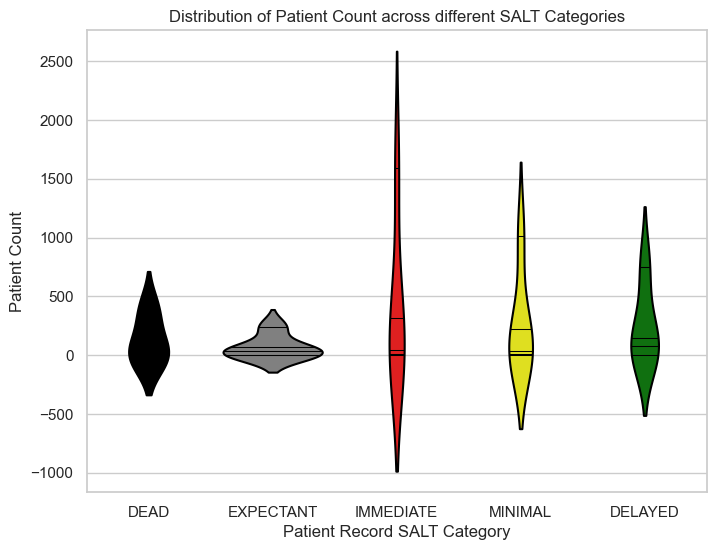

In [10]:

show_violin_plots('max_salt', 'Patient Record SALT Category', title_suffix='SALT Categories', palette=tag_colors)

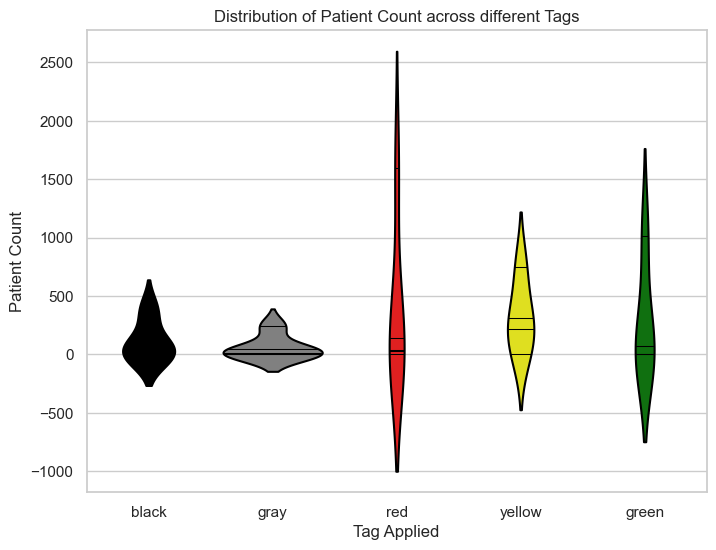

In [11]:

show_violin_plots('last_tag', 'Tag Applied', title_suffix='Tags', palette=tag_colors)

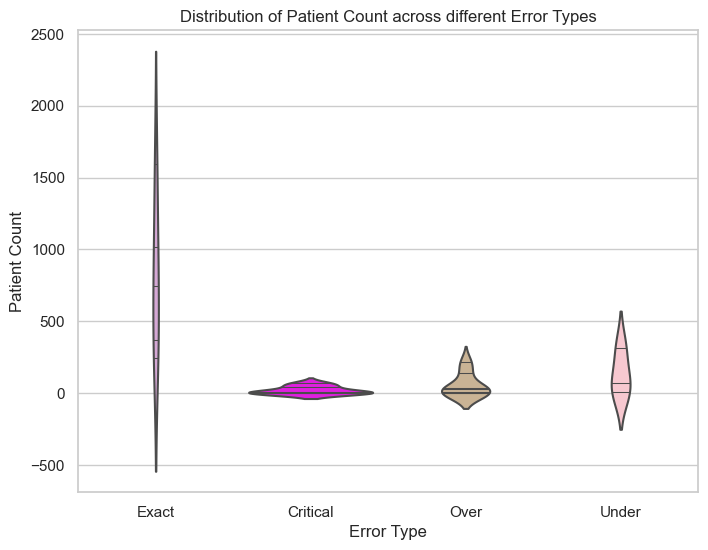

In [12]:

show_violin_plots('error_type', 'Error Type', title_suffix='Error Types', palette=error_colors)


## Display some pie charts


### Total pie chart

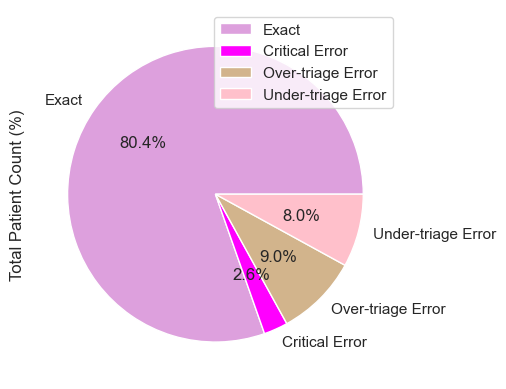

In [13]:

df = ERROR_TYPE_DF.groupby('error_type').sum().reset_index()
df.error_type = df.error_type
# display(nu.get_statistics(['patient_count'], df).applymap(lambda x: round(x, 1), na_action='ignore').T)
df.plot.pie(
    autopct='%1.1f%%', y='patient_count', ylabel='Total Patient Count (%)', labels=df.error_type.map(suffixed_fn),
    colors=[LABELS_DICT[k] for k in df.error_type]
);

In [14]:

def show_pie_charts(column_name, title_prefix='', suptitle=None):
    
    # Calculate the number of plots and the number of rows and columns
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    num_plots = len(unique_categories)
    num_rows = min(num_plots, 2)
    import numpy as np
    num_cols = int(np.ceil(num_plots / num_rows))
    
    # Create a figure and subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 9), sharex=False, sharey=False)
    
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').sum().reset_index()
        mask_series = (df.patient_count > 0)
        df[mask_series].plot.pie(
            autopct='%1.1f%%', y='patient_count', ylabel='', labels=df[mask_series].error_type.map(suffixed_fn),
            colors=[LABELS_DICT[k] for k in df[mask_series].error_type], ax=axs[i // num_cols, i % num_cols], title=f'{title_prefix}{column_value.title()}'
        );
    
    # Remove the remainder of the plots
    i += 1
    while i < (num_rows * num_cols):
        axs[i // num_cols, i % num_cols].remove()
        i += 1

    if suptitle is not None: fig.suptitle(suptitle)


### Pie charts grouped by max salt

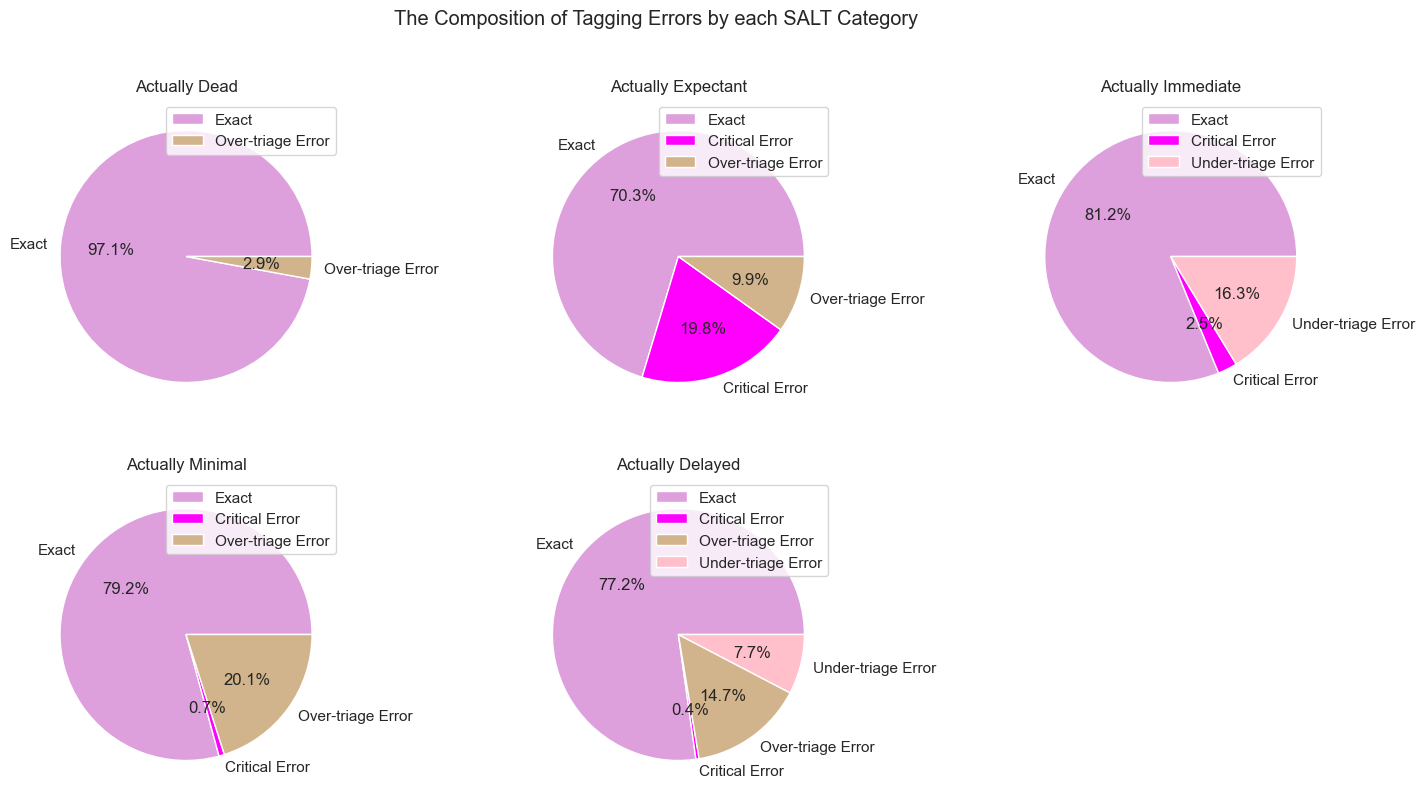

In [16]:

show_pie_charts('max_salt', title_prefix='Actually ', suptitle='The Composition of Tagging Errors by each SALT Category')


### Pie charts grouped by last tag

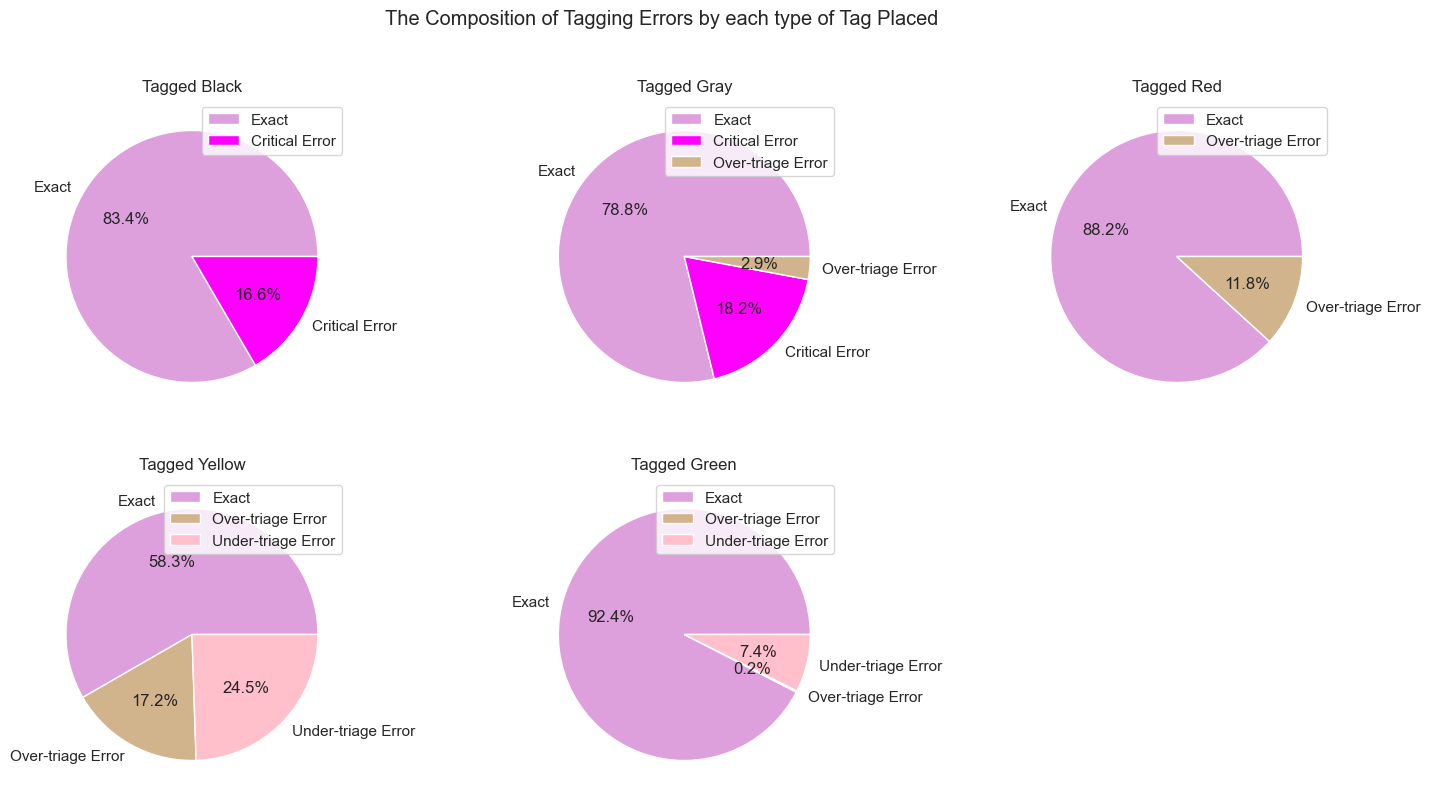

In [15]:

show_pie_charts('last_tag', title_prefix='Tagged ', suptitle='The Composition of Tagging Errors by each type of Tag Placed')


## Display some vertical bar charts


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_triage_accuracy.png" />

In [17]:

def show_vertical_bar_chart(column_name, title):
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    
    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    
    # Create data for each group
    data_list = []
    labels_list = ['']
    for i, column_value in enumerate(unique_categories):
        labels_list.append(column_value)
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').sum().reset_index()
        total_patient_count = df.patient_count.sum()
        mask_series = (df.error_type == 'Exact')
        accuracy_patient_count = df[mask_series].patient_count.sum()
        accuracy_patient_percent = 100*accuracy_patient_count/total_patient_count
        data_list.append(accuracy_patient_percent)
    
    # Create a bar chart
    ax.bar(range(len(data_list)), data_list, color=tag_colors)
    
    # Humanize x tick labels
    ax.set_xticklabels(labels_list)
    
    # Set the title, labels, and grid
    ax.set_title(title)
    ax.set_ylabel('Percent Accurate (%)')
    plt.grid(False)
    
    # Show the plot
    plt.show()


### Vertical bar charts grouped by max salt

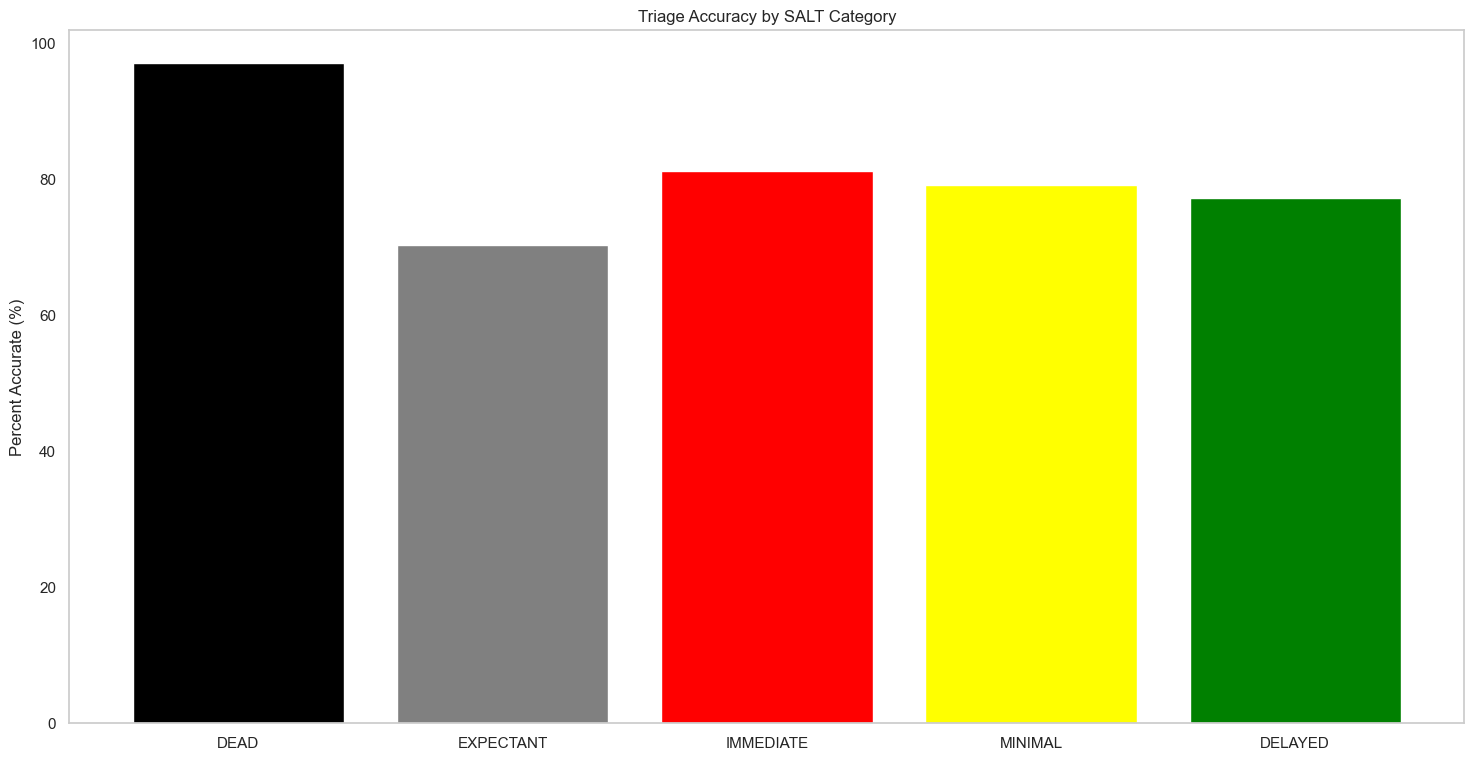

In [18]:

show_vertical_bar_chart('max_salt', 'Triage Accuracy by SALT Category')


### Vertical bar charts grouped by last tag

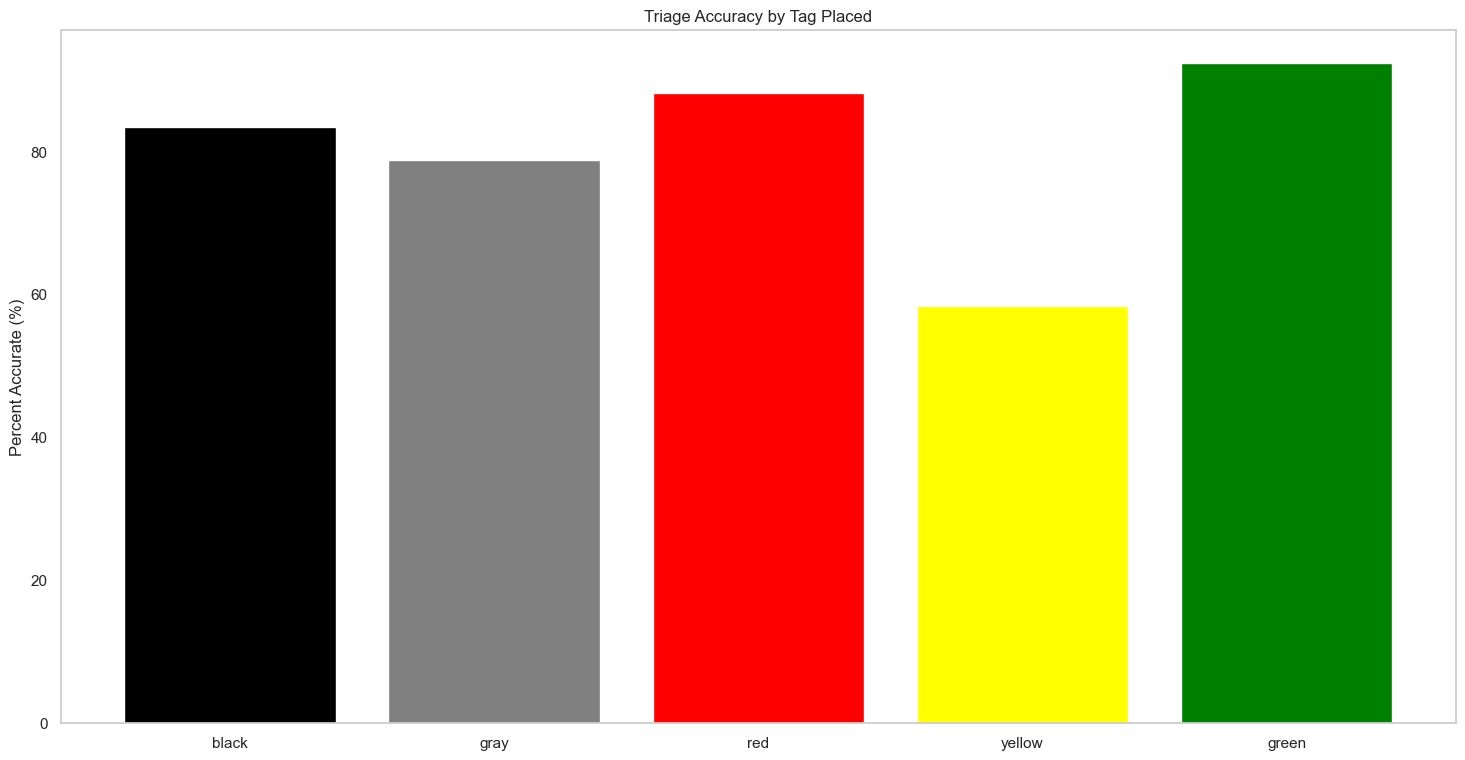

In [19]:

show_vertical_bar_chart('last_tag', 'Triage Accuracy by Tag Placed')


## Display some stacked horizontal bar charts


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_triage_errors.png" />

In [20]:

def show_stacked_horizontal_bar_chart(column_name, ylabel=''):
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    over_values = []
    under_values = []
    critical_values = []
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').sum().reset_index()
        total_patient_count = df.patient_count.sum()
        error_dict = df.set_index('error_type').patient_count.to_dict()
        over_patient_count = error_dict.get('Over', 0)
        over_values.append(100*over_patient_count/total_patient_count)
        under_patient_count = error_dict.get('Under', 0)
        under_values.append(100*under_patient_count/total_patient_count)
        critical_patient_count = error_dict.get('Critical', 0)
        critical_values.append(100*critical_patient_count/total_patient_count)
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(unique_categories, over_values, color='tan', label='Over-triage Error')
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(unique_categories, under_values, color='pink', label='Under-triage Error', left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    critical_bar = plt.barh(unique_categories, critical_values, color='fuchsia', label='Critical Error', left=[v1 + v2 for v1, v2 in zip(over_values, under_values)])
    
    # Annotate the values of each Value Set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center', color='black', fontsize=8
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(False)
    
    # Display the chart
    plt.show()


### Stacked horizontal bar charts grouped by max salt

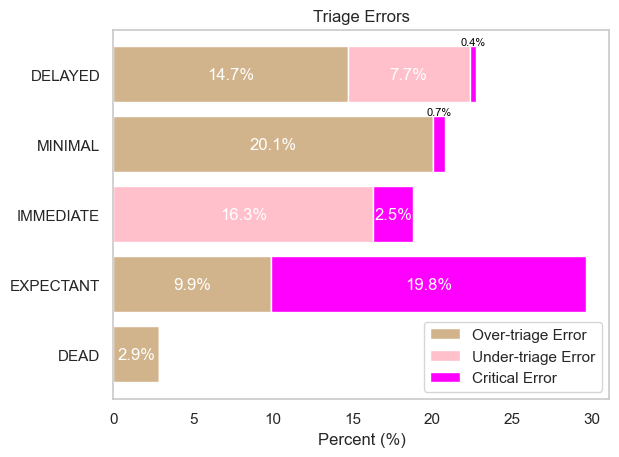

In [21]:

show_stacked_horizontal_bar_chart('max_salt', ylabel='')


### Stacked horizontal bar charts grouped by last tag

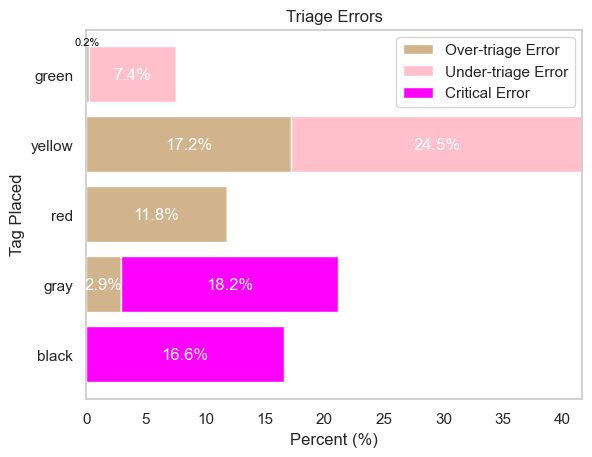

In [22]:

show_stacked_horizontal_bar_chart('last_tag', ylabel='Tag Placed')